In [65]:
from google.colab import drive
import pandas as pd
from IPython.core.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
from datetime import datetime, timedelta
import re

## Read in SKU + Sales Data

In [66]:
# ===============================================================
# 📂 BLOCK 2: MOUNT GOOGLE DRIVE & LOAD DATA FILES
# ===============================================================
drive.mount('/content/drive')

file_path1 = "/content/drive/MyDrive/IOE 424 (Gemline)/Data/SKU Data/SKU Attributes Report V2.xlsx"
file_path2 = "/content/drive/MyDrive/IOE 424 (Gemline)/Data/Sales and Pricing data/V3_Jan. 2022 to August 2025 Sales and Price data.xlsx"

# Load attribute file
df_sku_attributes = pd.read_excel(file_path1, engine="openpyxl")

# Category code → readable name
category_dict = {
    "*":      "COMMON",
    "BACKP":  "Backpack",
    "BBAGS":  "Business Bag",
    "COOL":   "Cooler",
    "DRINK":  "Drinkware",
    "DUF":    "Duffels",
    "FOOD":   "Food",
    "PAD":    "Padfolio",
    "STNRY":  "Stationery",
    "TECH":   "Technology",
    "TOTE":   "Totes",
    "TRAVL":  "Travel",
    "WRITE":  "Writing",
    "LFSTY":  "Lifestyle",
    "PPE":    "Personal Protective Equip.",
    "UMBR":   "Umbrellas",
    "HDWR":   "Headwear",
    "PKG":    "Packaging",
    "BLKTW":  "Blankets and Towels",
    "HOME":   "Home",
    "OFFCE":  "Office",
    "OUTDR":  "Outdoor",
    "SLWPK":  "Slings and Waist Packs",
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Merge Sales From 2022 - 2025

In [67]:
# ===============================================================
# 🧮 BLOCK 3: COMBINE SALES DATA (2022–2025)
# ===============================================================
sheet_names = [str(y) for y in range(2022, 2026)]
sheet_dict = pd.read_excel(file_path2, sheet_name=sheet_names, engine="openpyxl")

rename_map = {"Planned Ship Date/Time": "ShipDate", "Sales Qty": "SalesQty"}

frames = []
for name, df in sheet_dict.items():
    df = df.copy()
    df.columns = df.columns.str.strip()
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    if "ShipDate" in df.columns:
        df["ShipDate"] = pd.to_datetime(df["ShipDate"], errors="coerce")
    if "SalesQty" in df.columns:
        df["SalesQty"] = pd.to_numeric(df["SalesQty"], errors="coerce").fillna(0)
    if "Item" in df.columns:
        df["Item"] = df["Item"].astype(str).str.strip()

    df["year"] = int(name)
    frames.append(df)

combined_df = pd.concat(frames, ignore_index=True)

if "ShipDate" in combined_df.columns:
    combined_df = combined_df.dropna(subset=["ShipDate"]).reset_index(drop=True)


## Remove's SKU's w/out Subcategory Desc + Discontinued

In [68]:
# ===============================================================
# 🧹 BLOCK 4: CLEAN ATTRIBUTE HEADERS & DROP EMPTY FIELDS
# ===============================================================
df_sku_attributes.columns = df_sku_attributes.columns.str.strip()
df_sku_attributes["Item"] = df_sku_attributes["Item"].astype(str).str.strip()

subcat_col = "Subcategory Desc"
status_col = "Status Code"

# If CommGroup2 exists, we keep it, but do NOT filter on it anymore
commgroup2_col = "CommGroup2 Desc" if "CommGroup2 Desc" in df_sku_attributes.columns else None

before = len(df_sku_attributes)

# ✅ Only enforce: Subcategory Desc must exist + not blank
df_sku_attributes = df_sku_attributes[
    df_sku_attributes[subcat_col].astype(str).str.strip() != ""
]
df_sku_attributes = df_sku_attributes.dropna(subset=[subcat_col])

after = len(df_sku_attributes)

print(f"Removed {before - after} rows with empty '{subcat_col}'.")
print(f"Remaining rows (active only): {len(df_sku_attributes)}")


Removed 8 rows with empty 'Subcategory Desc'.
Remaining rows (active only): 2401


## Category Expanded Added + Intro Code Changed

In [69]:
# ===============================================================
# 🧭 BLOCK 5: CLEAN & ENRICH ATTRIBUTE DATA (No CommGroup2; All Categories)
# ===============================================================
def find_col(cols, target):
    t = target.lower().replace(' ', '').replace('_', '')
    for c in cols:
        if c.lower().replace(' ', '').replace('_', '') == t:
            return c
    raise KeyError(f"Column '{target}' not found.")

def find_col_optional(cols, target):
    try:
        return find_col(cols, target)
    except KeyError:
        return None

# --- Locate required/optional columns
item_col       = find_col(df_sku_attributes.columns, "Item")
category_col   = find_col(df_sku_attributes.columns, "Category")
subcat_col     = find_col(df_sku_attributes.columns, "Subcategory Desc")
intro_code_col = find_col(df_sku_attributes.columns, "Intro Code")
commgroup2_col = find_col_optional(df_sku_attributes.columns, "CommGroup2 Desc")  # optional now

# --- Standardize core text fields (only those that exist)
df_tmp = df_sku_attributes.copy()
for c in [item_col, category_col, subcat_col, intro_code_col, commgroup2_col]:
    if c is not None and c in df_tmp.columns:
        df_tmp[c] = df_tmp[c].astype(str).str.strip()

# --- Preserve raw intro code for OOC detection
df_tmp["Intro Code (Raw)"] = df_tmp[intro_code_col].astype(str).str.strip().str.upper()

# --- Expand category codes → readable names
cat_upper = df_tmp[category_col].str.upper()
df_tmp["Category (Expanded)"] = cat_upper.map(category_dict).fillna(df_tmp[category_col])

# --- Parse Intro Codes (e.g., "JAN 22" → Timestamp)
MONTHS = {m: i for i, m in enumerate(
    ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"], start=1)}

def parse_intro_code(code: str):
    if not code or str(code).upper() in {"NA", "NAN"}:
        return pd.NaT
    m = re.match(r'^\s*([A-Za-z]{3})\s*(\d{2})\s*$', str(code))
    if not m:
        return pd.NaT
    mon_abbr, yy = m.group(1).upper(), m.group(2)
    mon = MONTHS.get(mon_abbr)
    if not mon:
        return pd.NaT
    year = 2000 + int(yy)
    try:
        return pd.Timestamp(year=year, month=mon, day=1)
    except Exception:
        return pd.NaT

df_tmp["Intro_ParsedDate"] = df_tmp[intro_code_col].map(parse_intro_code)
df_tmp[intro_code_col] = df_tmp["Intro_ParsedDate"].dt.strftime("%b %Y")

# --- Canonical item key
df_tmp["Item_norm"] = df_tmp[item_col].astype(str).str.strip()

# ✅ NOTE:
# We no longer filter to Backpack and we no longer enforce/require CommGroup2.
# Any later logic should use Category (Expanded) and Subcategory Desc only.


In [70]:
# ===============================================================
# 🔗 BLOCK 6: MERGE SALES DATA WITH ATTRIBUTE DATA (No CommGroup2 dependency)
# ===============================================================
combined_df = combined_df.copy()
combined_df["Item_key"] = combined_df["Item"].astype(str).str.strip()

# --- Build the attribute slice columns dynamically ---
attr_cols = [item_col, "Item_norm", category_col, "Category (Expanded)",
             subcat_col, "Intro_ParsedDate", intro_code_col, "Intro Code (Raw)"]

# include CommGroup2 only if it exists
if ('CommGroup2 Desc' in df_tmp.columns) or (commgroup2_col is not None and commgroup2_col in df_tmp.columns):
    attr_cols.insert(attr_cols.index(subcat_col) + 1, commgroup2_col)  # place next to subcat

# Deduplicate by Item_norm, keep latest intro
attrs_slice = (
    df_tmp[attr_cols]
      .sort_values(["Item_norm", "Intro_ParsedDate"], na_position="last")
      .drop_duplicates(subset=["Item_norm"], keep="last")
)

# --- Build rename map safely (only for cols that are present) ---
rename_map = {
    item_col: "Item_attr",
    category_col: "Category",
    subcat_col: "Subcategory Desc",
    intro_code_col: "Intro Code",
}
if ("CommGroup2 Desc" in attrs_slice.columns) or (commgroup2_col in attrs_slice.columns):
    rename_map[commgroup2_col] = "CommGroup2 Desc"

attrs_slice = attrs_slice.rename(columns=rename_map)

# --- Merge onto sales ---
merged_sales = combined_df.merge(
    attrs_slice.rename(columns={"Item_norm": "Item_key"}),
    on="Item_key",
    how="left"
)

merged_sales["Item"] = merged_sales["Item_key"]
merged_sales = merged_sales.drop(columns=["Item_key"])

# ✅ NEW: ensure CommGroup2 Desc exists even if attributes didn’t have it
if "CommGroup2 Desc" not in merged_sales.columns:
    merged_sales["CommGroup2 Desc"] = "N/A"

# --- Diagnostics ---
print(f"Merged rows: {len(merged_sales):,}")
sample_cols = [c for c in ["Category", "Category (Expanded)", "Subcategory Desc",
                           "CommGroup2 Desc", "Intro Code", "Intro_ParsedDate"]
               if c in merged_sales.columns]
print("Sample columns now present:", sample_cols)

unmatched = merged_sales["Category"].isna().sum()
print(f"Unmatched sales rows (no attribute hit): {unmatched:,}")

# Drop unmatched for downstream simplicity
before_rows = len(merged_sales)
unmatched_mask = merged_sales["Category"].isna()
dropped_rows = int(unmatched_mask.sum())
merged_sales = merged_sales[~unmatched_mask].reset_index(drop=True)

print(f"Safety Check: Dropped unmatched sales rows: {dropped_rows:,}")
print(f"Remaining merged sales rows: {len(merged_sales):,}")


Merged rows: 624,603
Sample columns now present: ['Category', 'Category (Expanded)', 'Subcategory Desc', 'CommGroup2 Desc', 'Intro Code', 'Intro_ParsedDate']
Unmatched sales rows (no attribute hit): 205,216
Safety Check: Dropped unmatched sales rows: 205,216
Remaining merged sales rows: 419,387


In [71]:
# ===============================================================
# 🚫 BLOCK 6A: DROP OOC / PPE / PAD / <NA> / PRE-2022 INTRO CODES / NO-COLOR / NO-SUBCATEGORY
# ===============================================================
removed_counts = {}

# 1️⃣ Intro Code = OOC*
if "Intro Code (Raw)" in merged_sales.columns:
    mask_ooc = merged_sales["Intro Code (Raw)"].astype(str).str.upper().str.startswith("OOC")
else:
    mask_ooc = pd.Series(False, index=merged_sales.index)
removed_counts["Intro Code = OOC*"] = int(mask_ooc.sum())

# 2️⃣ Category = PPE or PAD
mask_badcat = merged_sales["Category"].astype(str).str.upper().isin(["PPE", "PAD"])
removed_counts["Category in {PPE, PAD}"] = int(mask_badcat.sum())

# 3️⃣ Category = <NA>
mask_na_cat = merged_sales["Category"].isna()
removed_counts["Category = <NA>"] = int(mask_na_cat.sum())

# 4️⃣ Intro Code (Parsed Date) before Jan 2022
if "Intro_ParsedDate" in merged_sales.columns:
    cutoff_date = pd.Timestamp(2022, 1, 1)
    mask_pre2022 = merged_sales["Intro_ParsedDate"].notna() & (merged_sales["Intro_ParsedDate"] < cutoff_date)
else:
    mask_pre2022 = pd.Series(False, index=merged_sales.index)
removed_counts["Intro Code before Jan 2022"] = int(mask_pre2022.sum())

# 5️⃣ Color missing / blank → drop (check nulls BEFORE casting to str)
if "Color" in merged_sales.columns:
    col_color = merged_sales["Color"]
    mask_nocolor = (
        col_color.isna() |
        col_color.astype(str).str.strip().eq("") |
        col_color.astype(str).str.lower().str.strip().isin({"nan", "none"})
    )
else:
    mask_nocolor = pd.Series(False, index=merged_sales.index)
removed_counts["Color missing/blank"] = int(mask_nocolor.sum())

# 6️⃣ Subcategory missing / blank → drop (needed for Category→Subcategory analysis)
if "Subcategory Desc" in merged_sales.columns:
    col_sub = merged_sales["Subcategory Desc"]
    mask_no_subcat = (
        col_sub.isna() |
        col_sub.astype(str).str.strip().eq("") |
        col_sub.astype(str).str.lower().str.strip().isin({"nan", "none"})
    )
else:
    mask_no_subcat = pd.Series(False, index=merged_sales.index)
removed_counts["Subcategory missing/blank"] = int(mask_no_subcat.sum())

# 🧹 Apply all drops
drop_mask = mask_ooc | mask_badcat | mask_na_cat | mask_pre2022 | mask_nocolor | mask_no_subcat
before_rows = len(merged_sales)
merged_sales = merged_sales[~drop_mask].reset_index(drop=True)

print("\nSummary of removed sales rows:")
for k, v in removed_counts.items():
    print(f"  {k}: {v}")
print(f"[Dropping] Remaining sales rows: {len(merged_sales):,}")

# Rows by year (if present)
if "year" in merged_sales.columns:
    print("[Dropping] Rows by year:")
    print(merged_sales["year"].value_counts().sort_index())



Summary of removed sales rows:
  Intro Code = OOC*: 1756
  Category in {PPE, PAD}: 0
  Category = <NA>: 0
  Intro Code before Jan 2022: 265130
  Color missing/blank: 0
  Subcategory missing/blank: 0
[Dropping] Remaining sales rows: 152,501
[Dropping] Rows by year:
year
2022    12545
2023    28911
2024    57569
2025    53476
Name: count, dtype: int64


# **Heatmaps**

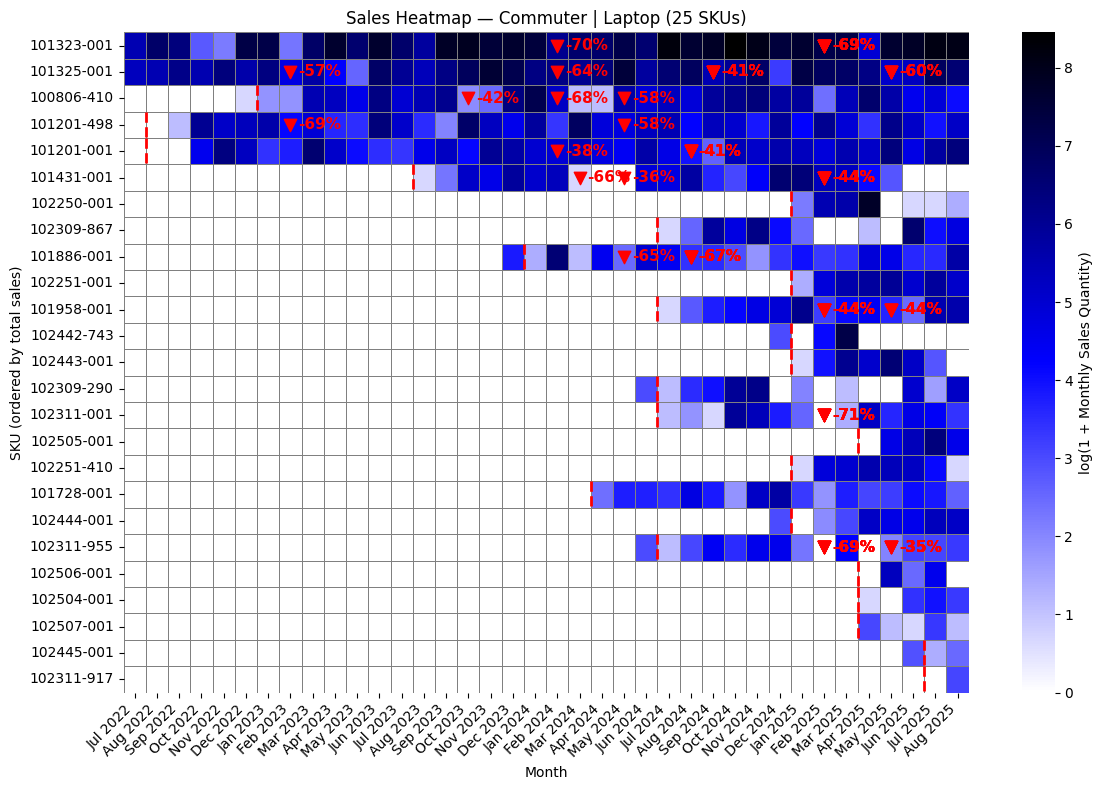

Potential Cannibalization Detected — Commuter | Laptop


,New_SKU,New_SKU_Intro,Affected_SKU,Drop_%,Drop_Start_Month
3,101886-001,2024-01-01,101323-001,-70,2024-02-01
27,102442-743,2025-01-01,101323-001,-69,2025-02-01
32,102444-001,2025-01-01,101323-001,-69,2025-02-01
37,102251-410,2025-01-01,101323-001,-69,2025-02-01
42,102443-001,2025-01-01,101323-001,-69,2025-02-01
...,...,...,...,...,...
56,102251-001,2025-01-01,102311-955,-69,2025-02-01
59,102504-001,2025-04-01,102311-955,-35,2025-05-01
62,102507-001,2025-04-01,102311-955,-35,2025-05-01
65,102505-001,2025-04-01,102311-955,-35,2025-05-01


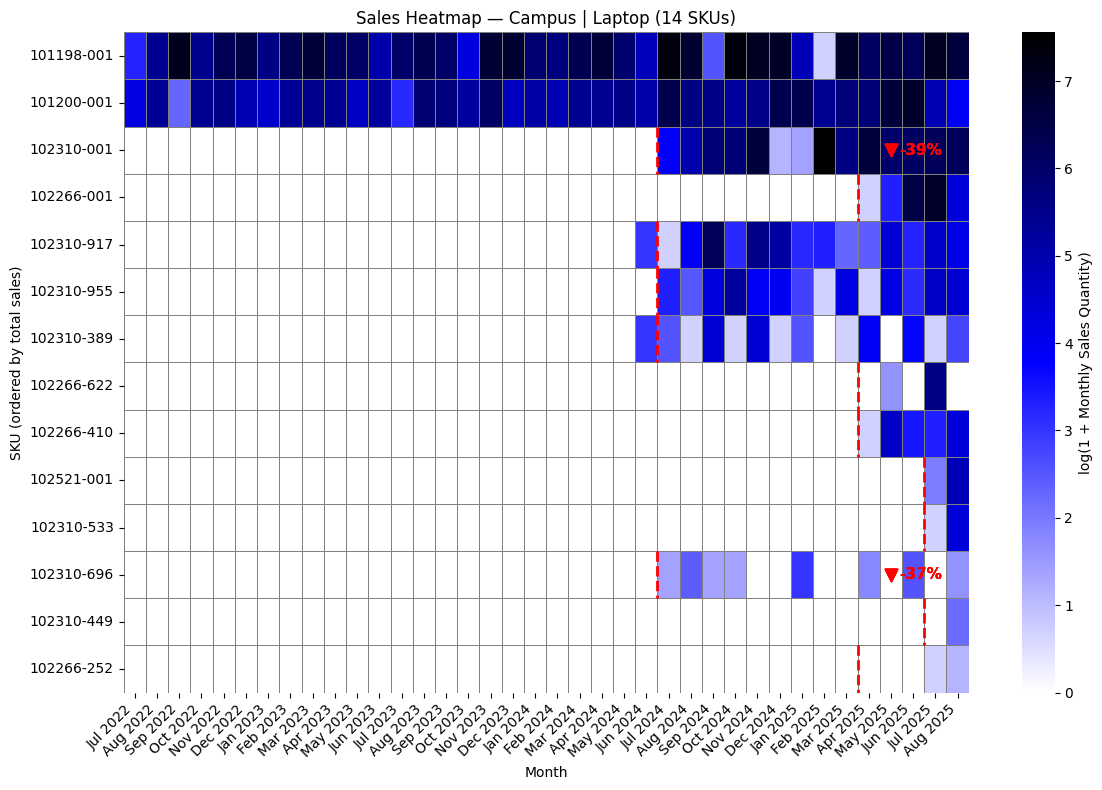

Potential Cannibalization Detected — Campus | Laptop


,New_SKU,New_SKU_Intro,Affected_SKU,Drop_%,Drop_Start_Month
0,102266-001,2025-04-01,102310-001,-39,2025-05-01
2,102266-410,2025-04-01,102310-001,-39,2025-05-01
4,102266-622,2025-04-01,102310-001,-39,2025-05-01
6,102266-252,2025-04-01,102310-001,-39,2025-05-01
1,102266-001,2025-04-01,102310-696,-37,2025-05-01
3,102266-410,2025-04-01,102310-696,-37,2025-05-01
5,102266-622,2025-04-01,102310-696,-37,2025-05-01
7,102266-252,2025-04-01,102310-696,-37,2025-05-01


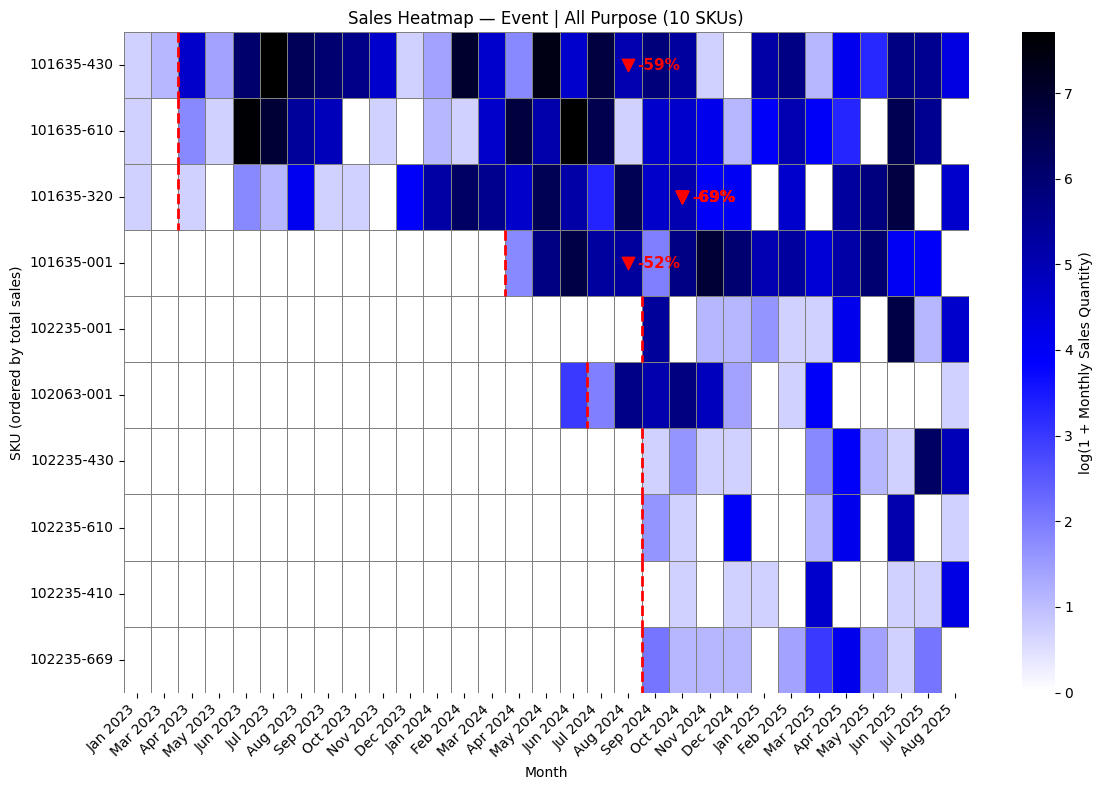

Potential Cannibalization Detected — Event | All Purpose


,New_SKU,New_SKU_Intro,Affected_SKU,Drop_%,Drop_Start_Month
0,102063-001,2024-07-01,101635-430,-59,2024-08-01
2,102235-669,2024-09-01,101635-320,-69,2024-10-01
3,102235-610,2024-09-01,101635-320,-69,2024-10-01
4,102235-430,2024-09-01,101635-320,-69,2024-10-01
5,102235-001,2024-09-01,101635-320,-69,2024-10-01
6,102235-410,2024-09-01,101635-320,-69,2024-10-01
1,102063-001,2024-07-01,101635-001,-52,2024-08-01


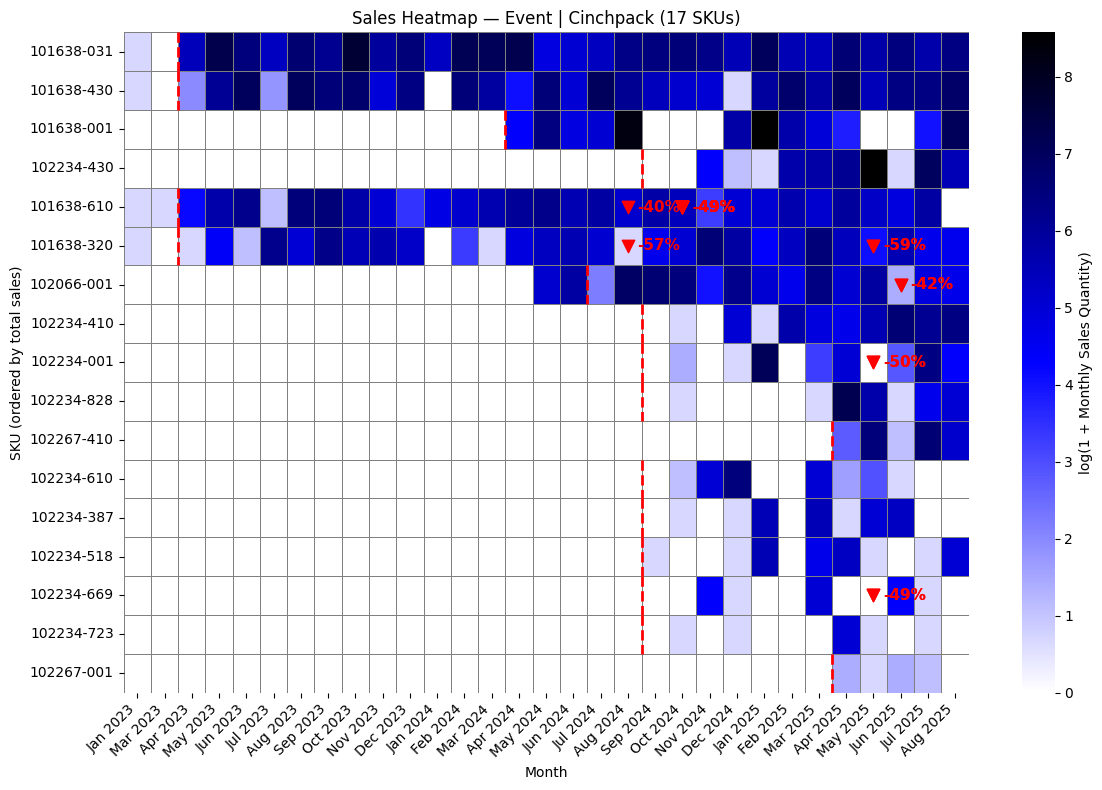

Potential Cannibalization Detected — Event | Cinchpack


,New_SKU,New_SKU_Intro,Affected_SKU,Drop_%,Drop_Start_Month
0,102066-001,2024-07-01,101638-610,-40,2024-08-01
2,102234-518,2024-09-01,101638-610,-49,2024-10-01
3,102234-828,2024-09-01,101638-610,-49,2024-10-01
4,102234-001,2024-09-01,101638-610,-49,2024-10-01
5,102234-387,2024-09-01,101638-610,-49,2024-10-01
6,102234-723,2024-09-01,101638-610,-49,2024-10-01
7,102234-410,2024-09-01,101638-610,-49,2024-10-01
8,102234-610,2024-09-01,101638-610,-49,2024-10-01
9,102234-430,2024-09-01,101638-610,-49,2024-10-01
10,102234-669,2024-09-01,101638-610,-49,2024-10-01


Skipping heatmap for Specialty | Baby — only 1 SKUs.


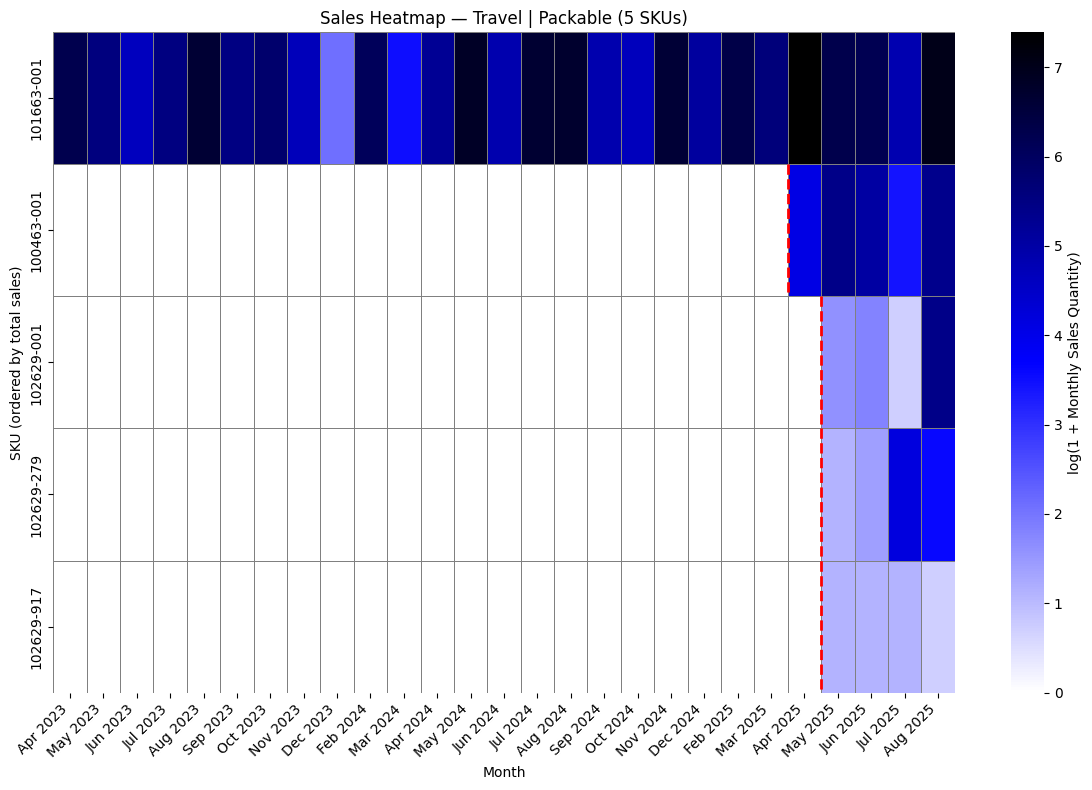

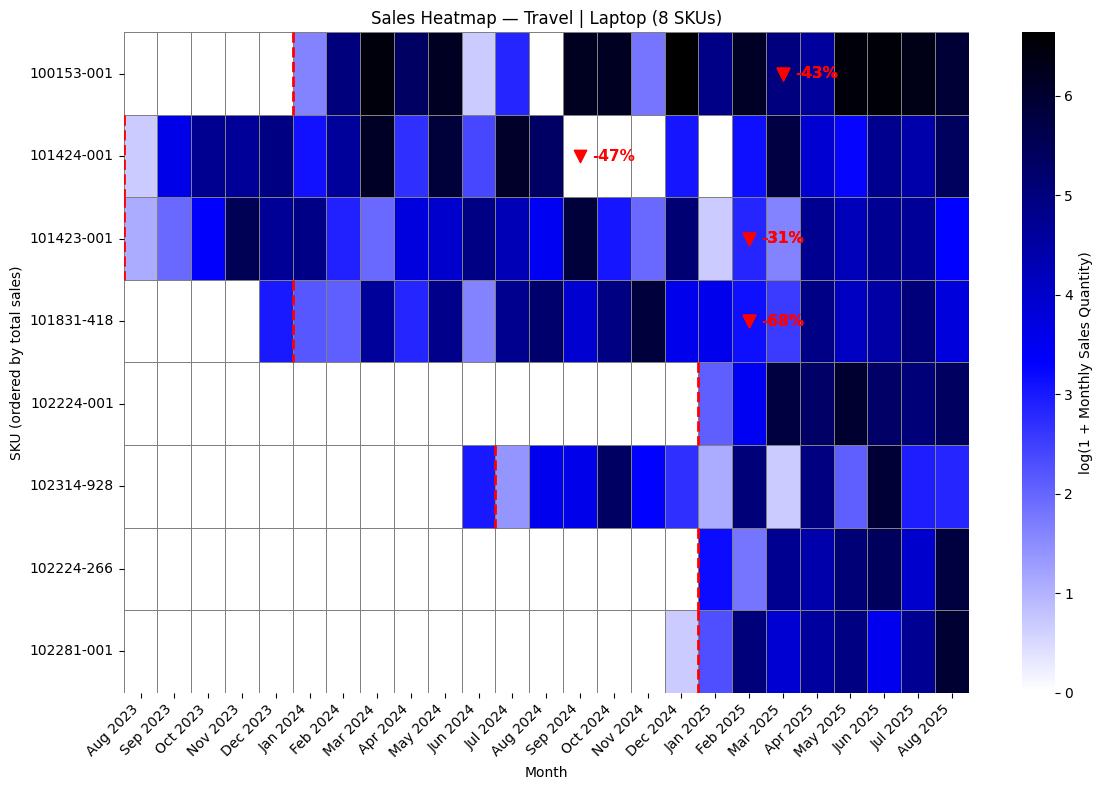

Potential Cannibalization Detected — Travel | Laptop


,New_SKU,New_SKU_Intro,Affected_SKU,Drop_%,Drop_Start_Month
1,102281-001,2025-01-01,100153-001,-43,2025-03-01
4,102224-266,2025-01-01,100153-001,-43,2025-03-01
7,102224-001,2025-01-01,100153-001,-43,2025-03-01
0,102314-928,2024-07-01,101424-001,-47,2024-09-01
2,102281-001,2025-01-01,101423-001,-31,2025-02-01
5,102224-266,2025-01-01,101423-001,-31,2025-02-01
8,102224-001,2025-01-01,101423-001,-31,2025-02-01
3,102281-001,2025-01-01,101831-418,-68,2025-02-01
6,102224-266,2025-01-01,101831-418,-68,2025-02-01
9,102224-001,2025-01-01,101831-418,-68,2025-02-01


Skipping heatmap for Travel | Convertible — only 1 SKUs.
Skipping heatmap for Travel | Cinchpack — only 1 SKUs.
Skipping heatmap for Commuter | Convertible — only 3 SKUs.
Skipping heatmap for Specialty | Trades — only 1 SKUs.
Skipping heatmap for Travel | Wheeled — only 4 SKUs.
Skipping heatmap for Campus | All Purpose — only 2 SKUs.


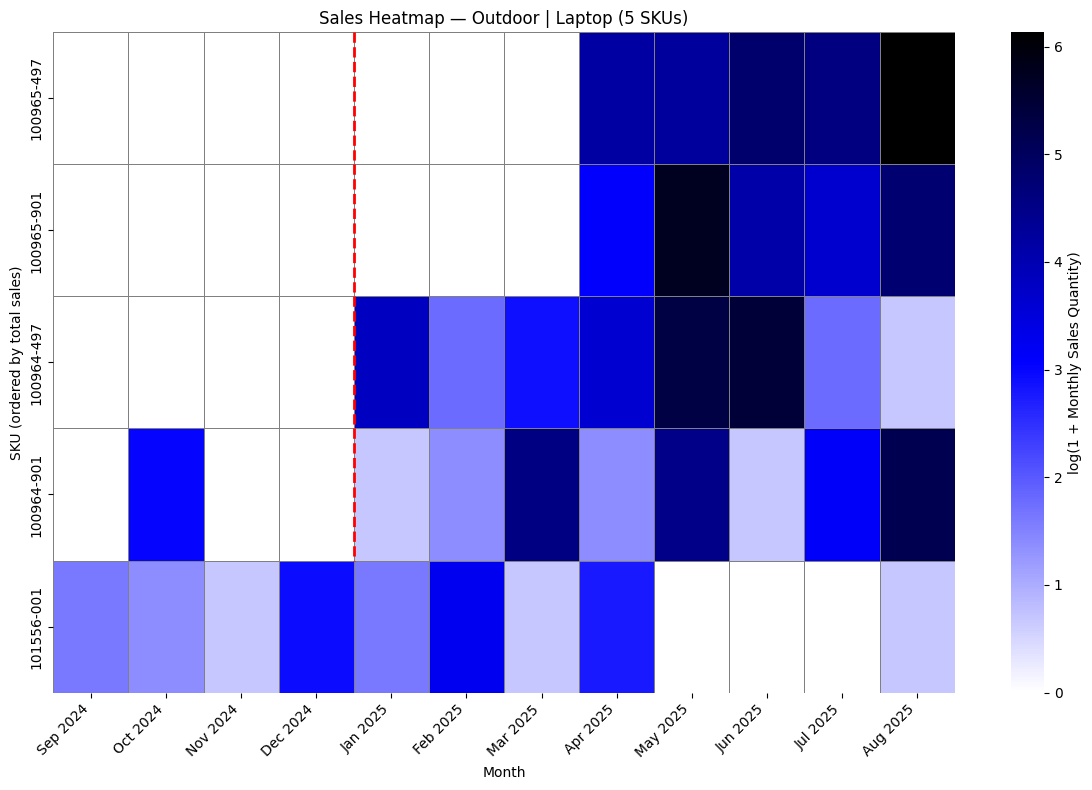

Skipping heatmap for Event | Clear — only 3 SKUs.
Skipping heatmap for Campus | Cinchpack — only 3 SKUs.
Skipping heatmap for Computer | Laptop — only 4 SKUs.
Skipping heatmap for Sport | Laptop — only 3 SKUs.


In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

"""
detects cannibalization by computing the mean sales 3 months before
and 3 months after (exclusive) a new product is introduced for every
other SKU active before that introduction.

if the sales drop by >= 30% in the 3 month period after, then the
SKU is marked as potentially cannibalized
"""
def detect_cannibalization_detailed(pivot_df, sku_intro_map, drop_threshold_min=0.3, drop_threshold_max=0.8, window=3):
    records = []
    months = pivot_df.columns

    for new_sku, intro_dt in sku_intro_map.items():
        if new_sku not in pivot_df.index or pd.isna(intro_dt):
            continue
        intro_month = intro_dt.to_period("M").to_timestamp()
        if intro_month not in months:
            continue

        intro_idx = np.where(months == intro_month)[0][0]
        post_start_idx = intro_idx + 1
        post_end_idx = post_start_idx + window

        # Require full post-intro window (full 3 months of data after intro)
        if post_end_idx > len(months):
            continue

        for other_sku in pivot_df.index:
            if other_sku == new_sku:
                continue

            pre_sales = pivot_df.loc[other_sku, months[max(0, intro_idx - window):intro_idx]]
            post_sales = pivot_df.loc[other_sku, months[post_start_idx:post_end_idx]]

            if pre_sales.mean() > 0:
                pct_change = (post_sales.mean() - pre_sales.mean()) / pre_sales.mean()
                # Only consider drops between drop_threshold_min and drop_threshold_max
                if -drop_threshold_max <= pct_change <= -drop_threshold_min:
                    drop_month_idx = post_start_idx + np.argmax(post_sales.values < pre_sales.mean()) \
                        if any(post_sales.values < pre_sales.mean()) else post_start_idx
                    drop_month = months[drop_month_idx]

                    records.append({
                        "New_SKU": new_sku,
                        "New_SKU_Intro": intro_month,
                        "Affected_SKU": other_sku,
                        "Drop_%": round(pct_change * 100),
                        "Drop_Start_Month": drop_month
                    })
    return pd.DataFrame(records)



#heatmap loop
cutoff = pd.Timestamp(2022, 1, 1)
backp_sales = merged_sales[
    (merged_sales["Category (Expanded)"] == "Backpack")
    & (merged_sales["Intro_ParsedDate"].notna())
    & (merged_sales["Intro_ParsedDate"] >= cutoff)
].copy()

backp_sales["ShipDate"] = pd.to_datetime(backp_sales["ShipDate"], errors="coerce")
backp_sales["Month"] = backp_sales["ShipDate"].dt.to_period("M").dt.to_timestamp()

sku_intro_map = (
    backp_sales[["Item", "Intro_ParsedDate"]]
    .drop_duplicates(subset=["Item"])
    .set_index("Item")["Intro_ParsedDate"]
    .to_dict()
)

pairs = (
    backp_sales[["Subcategory Desc", "CommGroup2 Desc"]]
    .dropna()
    .drop_duplicates()
    .itertuples(index=False, name=None)
)

for sub, grp2 in pairs:
    sub_df = backp_sales[
        (backp_sales["Subcategory Desc"] == sub) &
        (backp_sales["CommGroup2 Desc"] == grp2)
    ].copy()

    grouped = sub_df.groupby(["Month", "Item"], as_index=False)["SalesQty"].sum()
    pivot_df = grouped.pivot(index="Item", columns="Month", values="SalesQty").fillna(0)

    if pivot_df.empty:
        print(f"(No sales to plot for: {sub} | {grp2})")
        continue

    pivot_df["TotalSales"] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values("TotalSales", ascending=False).drop(columns="TotalSales")

    #keep only top 25 highest selling SKUs if a Category + Subcategory combination has more than 25 SKUs
    if len(pivot_df) > 25:
        pivot_df = pivot_df.head(25)

    #lower limit: 5 SKUs
    if len(pivot_df) < 5:
        print(f"Skipping heatmap for {sub} | {grp2} — only {len(pivot_df)} SKUs.")
        continue

    # lower limit: 7 months of data
    if pivot_df.shape[1] < 7:
      print(f"Skipping {cat} | {sub} — Only {pivot_df.shape[1]} months (need at least 7).")
      continue

    decline_df = detect_cannibalization_detailed(pivot_df, sku_intro_map)

    #plot
    heat_data = np.log1p(pivot_df)
    plt.figure(figsize=(12, 8))

    white_blu_bl = LinearSegmentedColormap.from_list("WBBl", ["white", "blue", "black"])

    ax = sns.heatmap(
        heat_data,
        cmap=white_blu_bl,
        cbar_kws={"label": "log(1 + Monthly Sales Quantity)"},
        linewidths=0.4,
        linecolor='gray'
    )

    plt.title(f"Sales Heatmap — {sub} | {grp2} ({len(pivot_df)} SKUs)")
    plt.xlabel("Month")
    plt.ylabel("SKU (ordered by total sales)")

    #x-axis labels
    ax.set_xticklabels(
        [pd.to_datetime(t.get_text()).strftime("%b %Y") for t in ax.get_xticklabels()],
        rotation=45, ha="right"
    )

    #mark intro months for SKUs
    for y, sku in enumerate(pivot_df.index):
        intro_dt = sku_intro_map.get(sku)
        if pd.notna(intro_dt):
            intro_month = intro_dt.to_period("M").to_timestamp()
            if intro_month in pivot_df.columns:
                x_idx = np.where(pivot_df.columns == intro_month)[0][0]
                ax.vlines(x_idx, y, y + 1, color="red", linestyle="--", linewidth=2)

    #mark declines w/ percentage value and arrow
    for _, row in decline_df.iterrows():
        affected_sku = row["Affected_SKU"]
        drop_month = row["Drop_Start_Month"]
        if affected_sku in pivot_df.index and drop_month in pivot_df.columns:
            y_idx = np.where(pivot_df.index == affected_sku)[0][0]
            x_idx = np.where(pivot_df.columns == drop_month)[0][0]
            ax.scatter(x_idx + 0.5, y_idx + 0.5, color="red", s=80, marker="v", zorder=5)  # upside-down triangle
            ax.text(x_idx + 0.85, y_idx + 0.5, f"{row['Drop_%']}%", color="red", fontsize=11, fontweight = "bold",
                    va="center", ha="left", zorder=6)

    plt.tight_layout()
    plt.show()

    #summary table (of potentially cannibalized SKUs)
    if not decline_df.empty:
        print(f"Potential Cannibalization Detected — {sub} | {grp2}")

        #reorder affected SKUs to match heatmap row order
        decline_df['Affected_SKU_order'] = decline_df['Affected_SKU'].apply(lambda x: np.where(pivot_df.index == x)[0][0])
        #order new SKUs by intro month
        months = pivot_df.columns
        decline_df['New_SKU_order'] = decline_df['New_SKU_Intro'].apply(lambda x: np.where(months == x)[0][0] if x in months else -1)

        #sort first by affected SKU (heatmap row), then by new SKU intro date
        decline_df_sorted = decline_df.sort_values(['Affected_SKU_order', 'New_SKU_order']).drop(
            columns=['Affected_SKU_order', 'New_SKU_order']
        )

        display(decline_df_sorted)


In [73]:
#seeing cannibalization across different colors in the same Category + Subcategory combination

#loading SKU attributes file
sku_attr = pd.read_excel(
    r"/content/drive/MyDrive/IOE 424 (Gemline)/Data/SKU Data/SKU Attributes Report V2.xlsx"
)

sku_attr = sku_attr.rename(columns={"Item #": "Item"})
sku_attr_small = sku_attr[["Item", "Color"]].drop_duplicates()

#merge color information with sales data
sales_with_color = merged_sales.merge(sku_attr_small, on="Item", how="left")

#removing rows w/o color
color_sales = sales_with_color[
    sales_with_color['Color'].notna() &
    sales_with_color['ShipDate'].notna()
].copy()
color_sales["ShipDate"] = pd.to_datetime(color_sales["ShipDate"], errors="coerce")
color_sales["Month"] = color_sales["ShipDate"].dt.to_period("M").dt.to_timestamp()

sku_intro_map = (
    color_sales[["Item", "Intro_ParsedDate"]]
    .drop_duplicates(subset=["Item"])
    .set_index("Item")["Intro_ParsedDate"]
    .to_dict()
)

#loop through each Category + Subcategory
pairs = (
    color_sales[["Category (Expanded)", "Subcategory Desc"]]
    .dropna()
    .drop_duplicates()
    .itertuples(index=False, name=None)
)

for cat, sub in pairs:
    sub_df = color_sales[
        (color_sales["Category (Expanded)"] == cat) &
        (color_sales["Subcategory Desc"] == sub)
    ].copy()

    #aggregating sales
    grouped = sub_df.groupby(["Month", "Item"], as_index=False)["SalesQty"].sum()
    pivot_df = grouped.pivot(index="Item", columns="Month", values="SalesQty").fillna(0)

    if pivot_df.empty:
        print(f"(No sales to plot for: {cat} | {sub})")
        continue

    #keep only the 25 highest selling SKUs
    pivot_df["TotalSales"] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values("TotalSales", ascending=False).head(25).drop(columns="TotalSales")

    #lower limit: 5 SKUs
    if pivot_df.shape[0] < 5:
        print(f"Skipping {cat} | {sub} — Only {pivot_df.shape[0]} SKUs (need at least 5).")
        continue

    # lower limit: 7 months of data
    if pivot_df.shape[1] < 7:
      print(f"Skipping {cat} | {sub} — Only {pivot_df.shape[1]} months (need at least 7).")
      continue

    decline_df = detect_cannibalization_detailed(pivot_df, sku_intro_map)

    # Convert Series → DataFrame
    if isinstance(decline_df, pd.Series):
      decline_df = decline_df.to_frame().T

    # None → empty DataFrame
    if decline_df is None:
      decline_df = pd.DataFrame()

    # Guarantee ALL expected columns exist
    expected_cols = ["New_SKU", "New_SKU_Intro", "Affected_SKU", "Drop_%", "Drop_Start_Month"]
    for col in expected_cols:
      if col not in decline_df.columns:
          decline_df[col] = None


    # --- add colors for new + affected SKUs ---

    sku_color_map = sku_attr_small.set_index("Item")["Color"]

    decline_df["New_Color"] = decline_df["New_SKU"].map(sku_color_map)
    decline_df["Affected_Color"] = decline_df["Affected_SKU"].map(sku_color_map)

    # shorten column labels (cleanest approach)
    pivot_df.columns = pivot_df.columns.to_series().dt.strftime("%b %y")

    #heatmap
    heat_data = np.log1p(pivot_df)
    plt.figure(figsize=(12, 8))

    white_blu_bl = LinearSegmentedColormap.from_list("WBBl", ["white", "blue", "black"])

    ax = sns.heatmap(
        heat_data,
        cmap=white_blu_bl,
        cbar_kws={"label": "log(1 + Monthly Sales Quantity)"},
        linewidths=0.4,
        linecolor='gray'
    )

    #adding color to Y-axis labels
    y_labels = [
        f"{sku} ({sales_with_color.loc[sales_with_color['Item'] == sku, 'Color'].iloc[0]})"
        for sku in pivot_df.index
    ]
    ax.set_yticklabels(y_labels, rotation=0, fontsize=8)

    plt.title(f"Sales Heatmap by Color — {cat} | {sub} ({len(pivot_df)} SKUs)")
    plt.xlabel("Month")
    plt.ylabel("SKU / Color")

    # label every month
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    ax.set_xticklabels(pivot_df.columns, rotation=45, ha="right")


    # -----------------------------
    # intro lines (converted to %b %y format)
    # -----------------------------
    for y, sku in enumerate(pivot_df.index):
        intro_dt = sku_intro_map.get(sku)
        if pd.notna(intro_dt):
            intro_label = intro_dt.to_period("M").to_timestamp().strftime("%b %y")
            if intro_label in pivot_df.columns:
                x_idx = np.where(pivot_df.columns == intro_label)[0][0]
                ax.vlines(
                    x_idx,
                    y,
                    y + 1,
                    color="red",
                    linestyle="--",
                    linewidth=2,
                )


    # -----------------------------
    # red arrows for % decline
    # -----------------------------
    for _, row in decline_df.iterrows():
        affected_sku = row["Affected_SKU"]
        drop_month = row["Drop_Start_Month"]

        drop_label = drop_month.strftime("%b %y")  # convert to match pivot_df labels

        if affected_sku in pivot_df.index and drop_label in pivot_df.columns:
            y_idx = np.where(pivot_df.index == affected_sku)[0][0]
            x_idx = np.where(pivot_df.columns == drop_label)[0][0]

            ax.scatter(x_idx + 0.5, y_idx + 0.5, color="red", s=80, marker="v", zorder=5)
            ax.text(
                x_idx + 0.85, y_idx + 0.5,
                f"{row['Drop_%']}%",
                color="red",
                fontsize=11,
                fontweight="bold",
                va="center",
                ha="left",
                zorder=6
           )

    plt.tight_layout()
    plt.show()

    #summary table
    if not decline_df.empty:
        print(f"Potential Cannibalization Between Colors — {cat} | {sub}")
        decline_df['Affected_SKU_order'] = decline_df['Affected_SKU'].apply(
            lambda x: np.where(pivot_df.index == x)[0][0]
        )
        months = pivot_df.columns
        decline_df['New_SKU_order'] = decline_df['New_SKU_Intro'].apply(
            lambda x: np.where(months == x)[0][0] if x in months else -1
        )
        decline_df_sorted = decline_df.sort_values(
            ['Affected_SKU_order', 'New_SKU_order']
        ).drop(columns=['Affected_SKU_order', 'New_SKU_order'])

        display(decline_df_sorted)


Output hidden; open in https://colab.research.google.com to view.

In [74]:
#cannibalization across brands

# Load SKU attributes file
sku_attr = pd.read_excel(
    r"/content/drive/MyDrive/IOE 424 (Gemline)/Data/SKU Data/SKU Attributes Report V2.xlsx"
)

sku_attr = sku_attr.rename(columns={"Item #": "Item"})
sku_attr_brand = sku_attr[["Item", "Brand"]].drop_duplicates()

# Merge brand information with sales
sales_with_brand = merged_sales.merge(sku_attr_brand, on="Item", how="left")

# Create SKU → Brand lookup dictionary
sku_brand_map = (
    sales_with_brand[["Item", "Brand"]]
    .dropna()
    .drop_duplicates()
    .set_index("Item")["Brand"]
    .to_dict()
)

# Keep rows that have both Brand and ShipDate
brand_sales = sales_with_brand[
    sales_with_brand["Brand"].notna() &
    sales_with_brand["ShipDate"].notna()
].copy()
brand_sales["ShipDate"] = pd.to_datetime(brand_sales["ShipDate"], errors="coerce")
brand_sales["Month"] = brand_sales["ShipDate"].dt.to_period("M").dt.to_timestamp()

# Build SKU → Intro Date lookup
sku_intro_map = (
    brand_sales[["Item", "Intro_ParsedDate"]]
    .drop_duplicates(subset=["Item"])
    .set_index("Item")["Intro_ParsedDate"]
    .to_dict()
)

# Loop through each Category + Subcategory
pairs = (
    brand_sales[["Category (Expanded)", "Subcategory Desc"]]
    .dropna()
    .drop_duplicates()
    .itertuples(index=False, name=None)
)

for cat, sub in pairs:
    sub_df = brand_sales[
        (brand_sales["Category (Expanded)"] == cat) &
        (brand_sales["Subcategory Desc"] == sub)
    ].copy()

    # Aggregate monthly sales per SKU
    grouped = sub_df.groupby(["Month", "Item"], as_index=False)["SalesQty"].sum()
    pivot_df = grouped.pivot(index="Item", columns="Month", values="SalesQty").fillna(0)

    if pivot_df.empty:
        print(f"(No sales to plot for: {cat} | {sub})")
        continue

    # Top 25 SKUs
    pivot_df["TotalSales"] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values("TotalSales", ascending=False).head(25).drop(columns="TotalSales")

    # Require at least 5 SKUs
    if pivot_df.shape[0] < 5:
        print(f"Skipping {cat} | {sub} — Only {pivot_df.shape[0]} SKUs (need at least 5).")
        continue

    #exclude cases where all SKUs are the same brand
    brands_in_group = (
      sales_with_brand[sales_with_brand["Item"].isin(pivot_df.index)]["Brand"]
      .dropna()
      .unique()
    )

    if len(brands_in_group) < 2:
      print(f"Skipping {cat} | {sub} — Only one brand present ({brands_in_group[0]}).")
      continue

    # lower limit: 7 months of data
    if pivot_df.shape[1] < 7:
      print(f"Skipping {cat} | {sub} — Only {pivot_df.shape[1]} months (need at least 7).")
      continue

    # Detect cannibalization
    decline_df = detect_cannibalization_detailed(
      pivot_df,
      {k: v for k, v in sku_intro_map.items() if k in pivot_df.index}  # restrict intros to shown SKUs
    )

    # add affected and new sku brands

    sku_brand_map = sku_attr_brand.set_index("Item")["Brand"].to_dict()

    white_blu_bl = LinearSegmentedColormap.from_list("WBBl", ["white", "blue", "black"])

    # Create heatmap
    heat_data = np.log1p(pivot_df)
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(
        heat_data,
        cmap=white_blu_bl,
        cbar_kws={"label": "log(1 + Monthly Sales Quantity)"},
        linewidths=0.3,
        linecolor='gray'
    )

    # Y-axis labels: SKU + Brand
    y_labels = [
        f"{sku} ({sales_with_brand.loc[sales_with_brand['Item'] == sku, 'Brand'].iloc[0]})"
        for sku in pivot_df.index
    ]
    ax.set_yticklabels(y_labels, rotation=0, fontsize=8)

    plt.title(f"Sales Heatmap by Brand — {cat} | {sub} ({len(pivot_df)} SKUs)")
    plt.xlabel("Month")
    plt.ylabel("SKU / Brand")

    # Format x-axis dates
    ax.set_xticklabels(
        [pd.to_datetime(t.get_text()).strftime("%b %Y") for t in ax.get_xticklabels()],
        rotation=45, ha="right"
    )

    # Vertical intro lines
    for y, sku in enumerate(pivot_df.index):
        intro_dt = sku_intro_map.get(sku)
        if pd.notna(intro_dt):
            intro_month = intro_dt.to_period("M").to_timestamp()
            if intro_month in pivot_df.columns:
                x_idx = np.where(pivot_df.columns == intro_month)[0][0]
                ax.vlines(x_idx, y, y + 1, color="red", linestyle="--", linewidth=2)

    # Red arrows + % decline
    # color-coded decline markers
    for _, row in decline_df.iterrows():
      affected_sku = row["Affected_SKU"]
      new_sku = row["New_SKU"]
      drop_month = row["Drop_Start_Month"]

      if (affected_sku not in pivot_df.index) or (drop_month not in pivot_df.columns):
        continue

      # Look up brands safely
      brand_affected = sku_brand_map.get(affected_sku)
      brand_new = sku_brand_map.get(new_sku)

      # Choose marker color
      if brand_affected and brand_new and (brand_affected != brand_new):
          marker_color = "#ff07fb"  # neon pink → cross-brand cannibalization
      else:
          marker_color = "red"      # same-brand cannibalization

      y_idx = np.where(pivot_df.index == affected_sku)[0][0]
      x_idx = np.where(pivot_df.columns == drop_month)[0][0]

      ax.scatter(x_idx + 0.5, y_idx + 0.5, color=marker_color, s=75, marker="v", zorder=5)
      ax.text(x_idx + 0.85, y_idx + 0.5, f"{row['Drop_%']}%", color=marker_color, fontsize=11, fontweight="bold",
            va="center", ha="left", zorder=6)


    plt.tight_layout()
    plt.show()

    # Summary table
    if not decline_df.empty:

        decline_df["New_Brand"] = decline_df["New_SKU"].map(sku_brand_map)
        decline_df["Affected_Brand"] = decline_df["Affected_SKU"].map(sku_brand_map)

        print(f"Potential Cannibalization Between Brands — {cat} | {sub}")
        decline_df['Affected_SKU_order'] = decline_df['Affected_SKU'].apply(lambda x: np.where(pivot_df.index == x)[0][0])
        months = pivot_df.columns
        decline_df['New_SKU_order'] = decline_df['New_SKU_Intro'].apply(lambda x: np.where(months == x)[0][0] if x in months else -1)
        decline_df_sorted = decline_df.sort_values(['Affected_SKU_order', 'New_SKU_order']).drop(
            columns=['Affected_SKU_order', 'New_SKU_order']
        )
        display(decline_df_sorted)


Output hidden; open in https://colab.research.google.com to view.